# Analysis of flood data

## Step 1: ricerca e download dataset
I dati vengono scaricati da [CREODIAS data explorer](https://explore.creodias.eu/search), per questo esempio ho selezionato date tra 01/09/2023 e 16/09/2023, e successivamente ho selezionato l'area interessata con lo strumento `Draw polygon` (primo quadratino nella lista a sinistra della mappa).

Da questa ricerca ottengo ~100 dataset, tra cui selezionare quelli che mi interessano. Per facilitare la ricerca, riducendo il numero di risultati da ispezionare, è quindi necessario:
* avere date il più precise possibile
* avere aree non troppo estese

Dai risultati ottenuti con questa ricerca ho selezionato dataset per cui:
* non ci sono aree "vuote" (in nero nelle preview dell'immagine)
* la copertura di nuvole è bassa (scarto le immagini in cui c'è molto bianco, anche indicato dalla percentuale di cloud coverage)

I dataset scelti possono essere aggiunti al proprio workspace tramite il pulsante con i tre pallini (se si è effettuato il login), per fare poi un'ispezione più approfondita.

Nel mio caso ho selezionato questi:
```
S2A_MSIL2A_20230915T092031_N0509_R093_T34SEJ_20230915T124358.SAFE
S2B_MSIL2A_20230910T091559_N0509_R093_T34SEJ_20230910T131613.SAFE
S2B_MSIL1C_20230910T091559_N0509_R093_T34SEJ_20230910T115323.SAFE
S2A_MSIL1C_20230915T092031_N0509_R093_T34SEJ_20230915T113427.SAFE
```

## Step 2: estrazione archivi e selezione immagini

I dataset si possono scaricare, sono degli archivi in formato zip. Una volta estratti tutti gli archivi ho cercato dentro ciascuno di questi file in formato `.jp2` che contenessero le stringhe `B03` (banda 3), `B11` (banda 11) e `SCL` (scene classification layer), come indicato nel [tutorial](https://creodias.docs.cloudferro.com/en/latest/cuttingedge/Analyzing-and-monitoring-floods-using-Python-and-Sentinel-2-satellite-imagery-on-Creodias.html)
Per trovare i file in questione sul mio pc è bastato entrare nella cartella in cui viene estratto l'archivio e digitare da terminale `find . -iname '*B03*.jp2*'` per trovare tutti i file che contengono `B03` e `jp2` nel nome. Penso che una cosa simile si possa fare da un file browser con qualsiasi sistema operativo. Ad esempio, per `B03` trovo questi file:
```
./GRANULE/L2A_T34SEJ_A042990_20230915T092828/IMG_DATA/R60m/T34SEJ_20230915T092031_B03_60m.jp2
./GRANULE/L2A_T34SEJ_A042990_20230915T092828/IMG_DATA/R20m/T34SEJ_20230915T092031_B03_20m.jp2
./GRANULE/L2A_T34SEJ_A042990_20230915T092828/IMG_DATA/R10m/T34SEJ_20230915T092031_B03_10m.jp2
```

Con questa procedura vedo che dentro i due archivi che contengono `MSIL1C` nel nome non ci sono dati `SCL`, quindi li scarto e tengo solo i due archivi `S2A_MSIL2A...` e `S2B_MSIL2A...`.

Dai nomi delle immagini vedo che ci sono diverse opzioni: 60m, 20m, 10m. Da quanto ho capito questi numeri sono riferiti alla risoluzione, scelgo quelli a risoluzione più alta.
I file "finali" che utilizzerò sono quindi:
```
./GRANULE/L2A_T34SEJ_A042990_20230915T092828/IMG_DATA/R60m/T34SEJ_20230915T092031_B03_60m.jp2
./GRANULE/L2A_T34SEJ_A042990_20230915T092828/IMG_DATA/R60m/T34SEJ_20230915T092031_B03_60m.jp2
./GRANULE/L2A_T34SEJ_A042990_20230915T092828/IMG_DATA/R60m/T34SEJ_20230915T092031_B03_60m.jp2
```

e i corrispondenti riferiti al 10/09/2023. Copio le 6 immagini in una cartella `image_data` dandogli nomi come nella cella 3 del notebook qua sotto: `band_3/11_before/after_flood.jp2` e `scl_image_before/after_flood.jp2`.

In [1]:
# Uncomment to run on colab
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/flood_data/flood_data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/flood_data/flood_data


In [2]:
!pwd

/content/drive/MyDrive/flood_data/flood_data


In [3]:
# Import libraries
!pip install --upgrade rasterio
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [4]:
# List of files to be used
input_band_3_b  = 'image_data/band_3_before_flood.jp2'
input_band_11_b = 'image_data/band_11_before_flood.jp2'
input_scl_b     = 'image_data/scl_image_before_flood.jp2'

input_band_3_f  = 'image_data/band_3_during_flood.jp2'
input_band_11_f = 'image_data/band_11_during_flood.jp2'
input_scl_f     = 'image_data/scl_image_during_flood.jp2'

In [5]:
# Function to open jp2
def open(raster):
    with rasterio.open(raster) as src:
        raster = src.read(1)
    return raster

In [6]:
#Get CRS and transformation data
with rasterio.open(input_scl_f) as src:
    crs = src.crs
    transform = src.transform

band_green_b= open(input_band_3_b)
band_swir_b = open(input_band_11_b)
scl_b = open(input_scl_b)

band_green_f = open(input_band_3_f)
band_swir_f = open(input_band_11_f)
scl_f = open(input_scl_f)

In [7]:
def normalize(band_green, band_swir):
    #Calculate maximum values for each raster file
    max_value = band_green.max()
    max_value = band_swir.max()

    #Normalize raster data to 0-255 scale
    scaled_band_green = (band_green / max_value) * 255
    scaled_band_swir = (band_swir/ max_value) * 255

    return scaled_band_green, scaled_band_swir


In [8]:
#Calculate MNDWI value for given images
def mndwi(scaled_band_green, scaled_band_swir):
    mndwi = (scaled_band_green - scaled_band_swir) / (scaled_band_green + scaled_band_swir)
    return mndwi

In [9]:
band_green_b, band_swir_b = normalize(band_green_b, band_swir_b)
band_green_f, band_swir_f = normalize(band_green_f, band_swir_f)

mndwi_b = mndwi(band_green_b, band_swir_b)
mndwi_f = mndwi(band_green_f, band_swir_f)

<ipython-input-10-e43b2c2f67cd>:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect to prevent the tight_layout affecting the colorbar


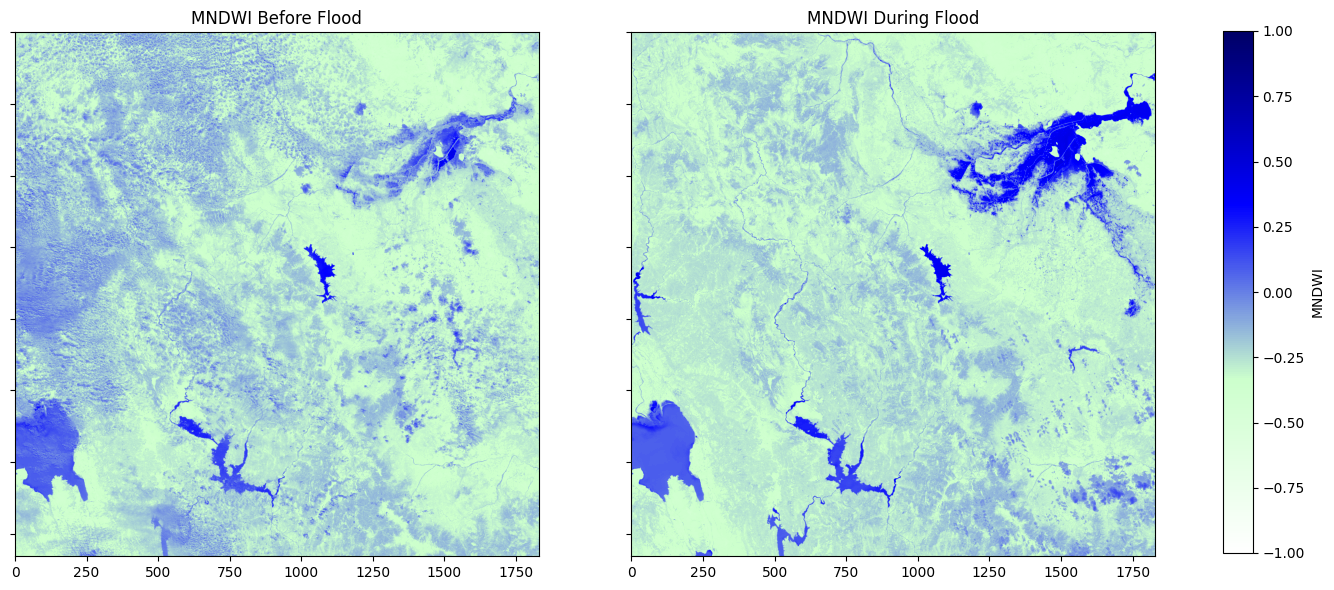

In [10]:
# Define a colormap that transitions from white to light green to blue to dark navy blue
colors = [(1, 1, 1), (0.8, 1, 0.8), (0, 0, 1), (0, 0, 0.4)]  # (R, G, B)
cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)

vmin, vmax = -1, 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
im = ax1.imshow(mndwi_b, cmap=cmap, vmin=vmin, vmax=vmax)
ax1.set_title('MNDWI Before Flood')
ax2.imshow(mndwi_f, cmap=cmap, vmin=vmin, vmax=vmax)
ax2.set_title('MNDWI During Flood')
ax2.set_yticklabels([])
fig.subplots_adjust(wspace=0.05, right=0.8)  # Reduce space between axes and make room for colorbar
cbar_ax = fig.add_axes([0.85, 0.07, 0.02, 0.87])  # Position and size of colorbar [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='MNDWI')
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect to prevent the tight_layout affecting the colorbar
plt.show()

In [11]:
# Create mask by SCL values
mask_f = np.logical_or(scl_f == 8, np.logical_or(scl_f == 9, scl_f == 3))
mask_b = np.logical_or(scl_b == 8, np.logical_or(scl_b == 9, scl_b == 3))
# Calculate difference between flood period and normal period
diff = mndwi_f - mndwi_b

#Calculate water tides by showing the pixcels that have positive difference values
tide = diff
tide[(diff < 0)] = 0
tide[mask_f | mask_b] = 0
tide = tide / tide.max()

#Calculate flood areas by showing the pixcels that have possitive difference values and had negative values of MNDWI before flood
flood = diff
flood[(diff < 0) | (mndwi_b > 0)] = 0
flood[mask_f | mask_b] = 0
flood = flood / flood.max()

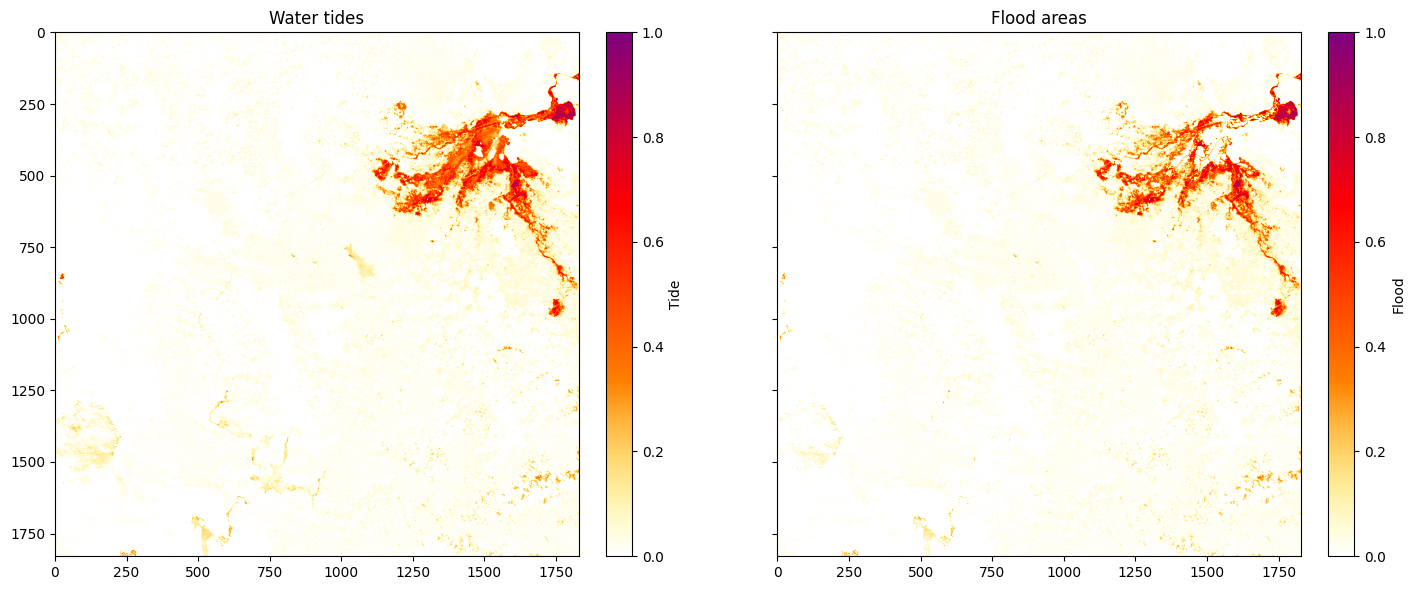

In [15]:
# Define a colormap that goes from yellow to red with transparency for 0 values and violet for high values
colors = [(1, 1, 0, 0), (1, 0.5, 0, 1), (1, 0, 0, 1), (0.5, 0, 0.5, 1)]  # (R, G, B, Alpha)
cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)

vmin, vmax = 0, 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
im1 = ax1.imshow(tide, cmap=cmap, vmin=vmin, vmax=np.max(tide))
ax1.set_title('Water tides')
cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
cbar1.set_label('Tide')

im2 = ax2.imshow(flood, cmap=cmap, vmin=vmin, vmax=np.max(flood))
ax2.set_title('Flood areas')
cbar2 = fig.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
cbar2.set_label('Flood')
plt.tight_layout()  # Adjust the rect to prevent the tight_layout affecting the colorbar
plt.show()

In [13]:
# Save postprocessed data as TIFF images
def save(raster, name):
    with rasterio.open(f"{name}.tif", 'w', driver='GTiff', width=raster.shape[1], height=raster.shape[0], count=1, dtype=raster.dtype, crs=crs, transform=transform) as dst:
        dst.write(raster, 1)


In [14]:
save(mndwi_b, 'mndwi_before_greece')
save(mndwi_f, 'mndwi_flood_greece')
save(tide, 'tide_greece')
save(flood, 'flood_greece')
